# Setup
## Import libraries

In [1]:
# Import the libraries and set the paths
import sys
import os
notebook_dir = os.getcwd()
root = os.path.abspath(os.path.join(notebook_dir, '../../'))
sys.path.append(root)

from utils.data.csv_parsing import load_csv_as_dicts, load_csv_as_dataframe

import getpass



## Load Data

In [2]:
# article_path = '/data/transformed/FA-KES.csv'

# articles = load_csv_as_dicts(root+article_path)
# articles_df = load_csv_as_dataframe(root+article_path)

## Load API Keys

In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("LANGSMITH_API_KEY")
_set_env("OPENAI_API_KEY")
_set_env("HUGGINGFACEHUB_API_TOKEN")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "FakeNews Detection"

In [4]:
from core.experiment import Experiment


def gen_experiment(
    experiment_name: str = "baseline_gpt4",
    verbose: bool = True,
):
    """
    Run a misinformation detection experiment.

    Args:
        experiment_name: Name of experiment config to use
        dataset_name: Name of dataset to evaluate
        verbose: Whether to print debug information
    """
    # Initialize and run experiment
    experiment = Experiment(
        experiment_name=experiment_name,
        description="Evaluating graph-based misinformation detection system.",
        verbose=verbose,
    )
    return experiment    

/Users/finlayduff/.pyenv/versions/3.10.4/envs/fakenews_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
exp = gen_experiment()

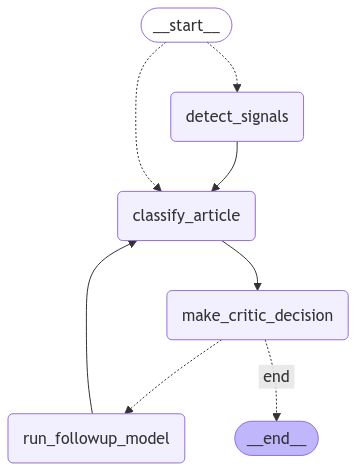

In [6]:
exp.graph_manager.visualize_graph()

# Graph Definition

In [7]:
open_ai_model_name = 'gpt-4o-mini-2024-07-18'
# anthropic_model_name = 'claude-3-haiku-20240307'
anthropic_model_name = 'claude-3-5-haiku-20241022'
meta_llama_model_name = "meta-llama/Llama-2-7b-chat-hf"

In [8]:
# # main.py
# 
from core.experiment import Experiment

# # Define the prompt name
prompt_name = "direct_naive_zero_shot_classification"
# # prompt_name = "direct_robust_zero_shot_classification"
# # prompt_name = "direct_few_shot_classification"


# # Instantiate the experiment
experiment = Experiment(
    article_classification_prompt_name=prompt_name,
    llm_model_name=open_ai_model_name,
    dataset_name="FA-KES debug",
    description="Evaluating graph-based misinformation detection system.",
    experiment_type="staged_classification",
    verbose=True,
    use_bulk_signals=False,
    local_llm=True,
)

# # Run the evaluation
results = experiment.run_evaluation()

TypeError: Experiment.__init__() got an unexpected keyword argument 'article_classification_prompt_name'

In [16]:
import json

# run_name = 'results/2024-12-29T17:43:02.244981_experiment_f81eac67-a503-4230-9e5d-9cded133ab8e.json'
run_name = "results/2025-01-04T12:09:48.297232_experiment_10b240cf-ea13-4c6b-a80d-8e59a4d9f540.json"
# Reading a JSON file
with open(run_name, 'r') as file:
    data = json.load(file)



In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer

# Initialize the pipeline and tokenizer
pipe = pipeline("text-classification", model="valurank/distilroberta-bias")
tokenizer = AutoTokenizer.from_pretrained("valurank/distilroberta-bias")

# Get the maximum sequence length
max_length = tokenizer.model_max_length

# Function to split text into chunks
def split_into_chunks(text, max_length):
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

results = []

for example in range(len(data['results']['examples'])):
    article_content = data['results']['examples'][example]['inputs']['article_content']
    
    # Split the article content into chunks
    chunks = split_into_chunks(article_content, max_length)
    
    # Process each chunk separately and aggregate the results
    bert_predictions = [pipe(chunk)[0] for chunk in chunks]
    
    # Aggregate the BERT predictions (e.g., by taking the majority vote or averaging the scores)
    bert_prediction = max(bert_predictions, key=lambda x: x['score'])
    
    llm_prediction = data['credibility_signals'][example]['bias']
    llm_article_classification = data['results']['runs'][example]['outputs']['label']
    actual_article_classification = data['results']['examples'][example]['outputs']['label']
    
    results.append({
        "article_content": article_content,
        "llm_prediction": llm_prediction['label'],
        "llm_confidence": llm_prediction['confidence'],
        "bert_prediction": bert_prediction['label'],
        "bert_confidence": bert_prediction['score'],
        "llm_article_classification": llm_article_classification,
        "actual_article_classification": actual_article_classification
    })

df = pd.DataFrame(results)
print(df)

In [23]:
df['bert_prediction'] = df['bert_prediction'].map({'BIASED': 0.0, 'NEUTRAL': 1.0})

In [ ]:
# Calculate the average LLM confidence when it agrees with BERT
llm_confidence_agreement = df[df['llm_prediction'] == df['bert_prediction']]['llm_confidence'].mean()

# Calculate the average LLM confidence when it disagrees with BERT
llm_confidence_disagreement = df[df['llm_prediction'] != df['bert_prediction']]['llm_confidence'].mean()

print(f"LLM Confidence when it agrees with BERT: {llm_confidence_agreement}")
print(f"LLM Confidence when it disagrees with BERT: {llm_confidence_disagreement}")
# Calculate the average BERT confidence when it agrees with LLM
bert_confidence_agreement = df[df['llm_prediction'] == df['bert_prediction']]['bert_confidence'].mean()

# Calculate the average BERT confidence when it disagrees with LLM
bert_confidence_disagreement = df[df['llm_prediction'] != df['bert_prediction']]['bert_confidence'].mean()

print(f"BERT Confidence when it agrees with LLM: {bert_confidence_agreement}")
print(f"BERT Confidence when it disagrees with LLM: {bert_confidence_disagreement}")
import matplotlib.pyplot as plt

# Plot the average confidence when LLM agrees vs disagrees with BERT
labels = ['LLM agrees with BERT', 'LLM disagrees with BERT']
llm_confidences = [llm_confidence_agreement, llm_confidence_disagreement]
bert_confidences = [bert_confidence_agreement, bert_confidence_disagreement]

x = range(len(labels))

fig, ax = plt.subplots()
ax.bar(x, llm_confidences, width=0.4, label='LLM Confidence', align='center')
ax.bar(x, bert_confidences, width=0.4, label='BERT Confidence', align='edge')

ax.set_xlabel('Agreement')
ax.set_ylabel('Average Confidence')
ax.set_title('Average Confidence of LLM and BERT')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [ ]:

# Rename the columns for better readability
grouped_counts.columns = ['llm_counts', 'bert_counts']
grouped_counts.index.name = 'llm_prediction'
grouped_counts.reset_index(inplace=True)

print("\nGrouped Counts:")
print(grouped_counts)


In [ ]:
article_content = articles_df.loc[articles_df.article_title == 'Al-Nusra Spokesman Son 20 Terrorists Killed in Idleb Strikes']['article_content'].iloc[0]
pipe(article_content)